In [1]:
import numpy as np

# 定义标准氨基酸表
AMINO_ACIDS = "ACDEFGHIKLMNPQRSTVWY"
AMINO_MAP = {aa: i for i, aa in enumerate(AMINO_ACIDS)}

def parse_fasta(file_path):
    sequences = []
    labels = []
    current_seq = []
    current_label = None
    
    with open(file_path, "r") as f:
        for line in f:
            line = line.strip()
            if line.startswith(">"):  # Header line
                if current_seq and current_label is not None:
                    sequences.append("".join(current_seq))
                    labels.append(current_label)
                    current_seq = []
                
                # Extract label
                if "functional_true" in line:
                    current_label = 1.0
                elif "functional_false" in line:
                    current_label = 0.0
                else:
                    raise ValueError(f"Unknown functional label in header: {line}")
            else:
                # Sequence line
                current_seq.append(line)
        
        # Append the last sequence
        if current_seq and current_label is not None:
            sequences.append("".join(current_seq))
            labels.append(current_label)
    
    return sequences, labels

def one_hot_encode_sequence(sequence):
    """将蛋白质序列转换为独热编码"""
    one_hot = np.zeros((len(sequence), 20), dtype=int)
    for i, aa in enumerate(sequence):
        if aa in AMINO_MAP:
            one_hot[i, AMINO_MAP[aa]] = 1
    return one_hot

def process_fasta(file_path):
    sequences, labels = parse_fasta(file_path)
    encoded_sequences = [one_hot_encode_sequence(seq) for seq in sequences]
    return encoded_sequences, np.array(labels)

file_path = './MSA_nat_with_annotation.faa'
art_file_path = './MSA_art.faa'

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"  # 输出所有结果
temp_se,temp_labels = process_fasta(art_file_path)
print(temp_labels[0].dtype)


float64


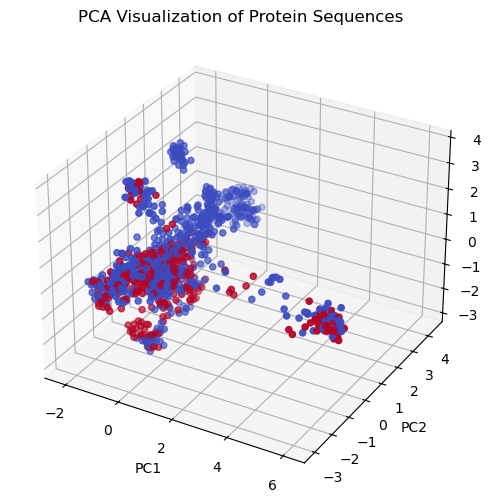

In [3]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
def pca_visualization(encoded_sequences, labels):
    """
    使用PCA进行降维并可视化序列数据。
    :param encoded_sequences: 独热编码后的序列
    :param labels: 对应的功能性标签 (0表示非功能性，1表示功能性)
    """
    # 将序列列表转换为二维数组 (样本数, 特征数)
    encoded_sequences = np.array(encoded_sequences).reshape(len(encoded_sequences), -1)
    
    # 使用PCA降维至3个主成分
    pca = PCA(n_components=3)
    pca_result = pca.fit_transform(encoded_sequences)

    # 可视化
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2], c=labels, cmap='coolwarm')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    plt.title('PCA Visualization of Protein Sequences')
    plt.show()

# 读取FASTA文件、编码序列并进行PCA可视化
encoded_sequences, labels = process_fasta(file_path)
pca_visualization(encoded_sequences, labels)

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


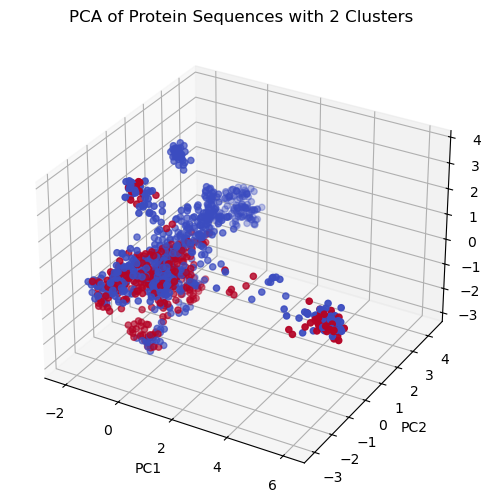

In [4]:
from sklearn.cluster import KMeans
def pca_visualization_with_clusters(encoded_sequences, labels, n_clusters=2):
    """
    使用PCA进行降维、聚类并可视化结果。
    :param encoded_sequences: 独热编码后的序列
    :param labels: 功能性标签 (0表示非功能性，1表示功能性)
    :param n_clusters: 聚类数 (默认3个聚类)
    """
    # 将序列列表转换为二维数组 (样本数, 特征数)
    encoded_sequences = np.array(encoded_sequences).reshape(len(encoded_sequences), -1)
    
    # 使用PCA降维至20个主成分
    pca = PCA(n_components=20)
    pca_result = pca.fit_transform(encoded_sequences)
    
    # 使用KMeans聚类
    kmeans = KMeans(n_clusters=n_clusters,max_iter=1000)
    cluster_labels = kmeans.fit_predict(pca_result)
    
    # 可视化PCA降维结果与聚类

    #根据聚类结果绘制数据点绘制三维图
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2], c=labels, cmap='coolwarm')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    plt.title('PCA Visualization of Protein Sequences')
    plt.title(f'PCA of Protein Sequences with {n_clusters} Clusters')
    plt.show()

encoded_sequences, labels = process_fasta(file_path)

pca_visualization_with_clusters(encoded_sequences, labels, n_clusters=2)

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.nn.functional as F


class ProteinClassifier(nn.Module):
    def __init__(self, input_dim):
        super(ProteinClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 8)
        self.fc4 = nn.Linear(8, 1)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc4(x))
        return x

def GetAndSavePCAAndScalerData(encoded_sequences,n_components=50):
    """
    对独热编码后的序列进行PCA降维。
    :param encoded_sequences: 独热编码后的序列，可能是三维数组
    :param n_components: PCA降维的目标维度
    :return: 降维后的序列
    """
    # 确保输入是一个 NumPy 数组
    encoded_sequences = np.array(encoded_sequences)
    # 如果是三维数据，则将其展平为二维
    if len(encoded_sequences.shape) == 3:
        batch_size, seq_length, feature_dim = encoded_sequences.shape
        encoded_sequences = encoded_sequences.reshape(batch_size, seq_length * feature_dim)
    #归一化数据，使得数据的均值为0，方差为
    scaler1 = StandardScaler()
    sequences_scaled = scaler1.fit_transform(encoded_sequences)
    # PCA降维
    pca = PCA(n_components=n_components)
    sequences_pca = pca.fit_transform(sequences_scaled)
    #再次进行归一化
    scaler2 = StandardScaler()
    sequences_pca = scaler2.fit_transform(sequences_pca)
    return scaler1,scaler2,pca
def apply_pca(encoded_sequences,scaler1,scaler2,pca):
    """
    对独热编码后的序列进行PCA降维。
    :param encoded_sequences: 独热编码后的序列，可能是三维数组
    :param n_components: PCA降维的目标维度
    :return: 降维后的序列
    """
    # 确保输入是一个 NumPy 数组
    encoded_sequences = np.array(encoded_sequences)

    # 如果是三维数据，则将其展平为二维
    if len(encoded_sequences.shape) == 3:
        batch_size, seq_length, feature_dim = encoded_sequences.shape
        encoded_sequences = encoded_sequences.reshape(batch_size, seq_length * feature_dim)

    #归一化数据，使得数据的均值为0，方差为
    sequences_scaled = scaler1.transform(encoded_sequences)
    # PCA降维
    sequences_pca = pca.transform(sequences_scaled)
    #再次进行归一化
    sequences_pca = scaler2.transform(sequences_pca)
    return sequences_pca


def prepare_data(train_data, test_data, use_pca=True, n_components=20):
    """
    根据是否使用PCA降维，准备训练和测试数据，转换为PyTorch的Tensor。
    """
    if use_pca:
        scaler1,scaler2,pca = GetAndSavePCAAndScalerData(train_data[0],n_components)
        X_train = apply_pca(train_data[0],scaler1,scaler2,pca)
        X_test = apply_pca(test_data[0],scaler1,scaler2,pca)
    else:
        X_train = train_data[0]
        X_test = test_data[0]

    # 转换为Tensor格式
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(train_data[1], dtype=torch.float32).view(-1, 1)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(test_data[1], dtype=torch.float32).view(-1, 1)

    return X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor


def train_model(model, train_loader, criterion, optimizer, device, num_epochs=20):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # 前向传播
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # 反向传播 + 优化
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')


def test_model(model, X_input, device):
    model.eval()
    y_pred = []

    with torch.no_grad():
        for inputs in X_input:
            inputs = inputs.to(device)
            outputs = model(inputs)
            predictions = (outputs > 0.5).float()
            y_pred.extend(predictions.cpu().numpy())

    return  y_pred



In [6]:

train_data = process_fasta(file_path)
test_data = process_fasta(art_file_path)

X_train, y_train, X_test, y_test = prepare_data(train_data, test_data, use_pca=True, n_components=40)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

input_dim = X_train.shape[1] 
model = ProteinClassifier(input_dim)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.BCELoss()  # 二分类交叉熵损失
#class_weights = torch.tensor([1.0, 2.0], dtype=torch.float32).to(device) 
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# 训练模型
train_model(model, train_loader, criterion, optimizer, device, num_epochs=2000)
# 测试模型
y_pred = test_model(model, X_train, device)

ProteinClassifier(
  (fc1): Linear(in_features=40, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=8, bias=True)
  (fc4): Linear(in_features=8, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

Epoch [1/2000], Loss: 0.6721
Epoch [2/2000], Loss: 0.6675
Epoch [3/2000], Loss: 0.6673
Epoch [4/2000], Loss: 0.6635
Epoch [5/2000], Loss: 0.6635
Epoch [6/2000], Loss: 0.6619
Epoch [7/2000], Loss: 0.6587
Epoch [8/2000], Loss: 0.6575
Epoch [9/2000], Loss: 0.6550
Epoch [10/2000], Loss: 0.6475
Epoch [11/2000], Loss: 0.6423
Epoch [12/2000], Loss: 0.6277
Epoch [13/2000], Loss: 0.6115
Epoch [14/2000], Loss: 0.5963
Epoch [15/2000], Loss: 0.5852
Epoch [16/2000], Loss: 0.5618
Epoch [17/2000], Loss: 0.5549
Epoch [18/2000], Loss: 0.5363
Epoch [19/2000], Loss: 0.5290
Epoch [20/2000], Loss: 0.5087
Epoch [21/2000], Loss: 0.4936
Epoch [22/2000], Loss: 0.5103
Epoch [23/2000], Loss: 0.5122
Epoch [24/2000], Loss: 0.5101
Epoch [25/2000], Loss: 0.4941
Epoch [26/2000], Loss: 0.4815
Epoch [27/2000], Loss: 0.4816
Epoch [28/2000], Loss: 0.4823
Epoch [29/2000], Loss: 0.4656
Epoch [30/2000], Loss: 0.4631
Epoch [31/2000], Loss: 0.4858
Epoch [32/2000], Loss: 0.4607
Epoch [33/2000], Loss: 0.4722
Epoch [34/2000], Lo

[1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

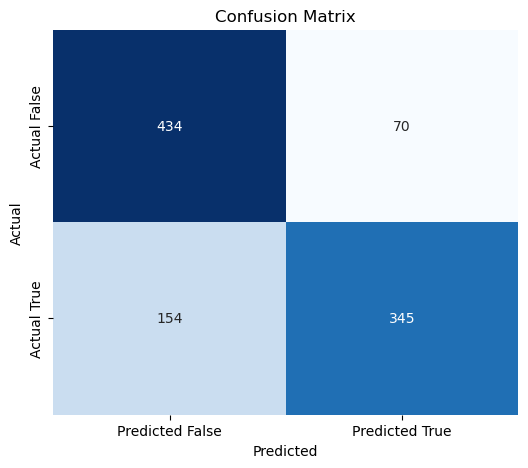

In [7]:
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score
def evaluate_model(y_true, y_pred):
    """
    评估模型效果，输出混淆矩阵并提取 TP, FP, TN, FN
    :param y_true: 真实标签
    :param y_pred: 预测标签
    :return: None
    """
    # 计算混淆矩阵
    cm = confusion_matrix(y_true, y_pred)
    
    # 提取 TP, FP, TN, FN
    TN, FP, FN, TP = cm.ravel()
    
    # 输出混淆矩阵
    print("Confusion Matrix:")
    print(cm)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"True Positive (TP): {TP}")
    print(f"False Positive (FP): {FP}")
    print(f"True Negative (TN): {TN}")
    print(f"False Negative (FN): {FN}")
    
    # 可视化混淆矩阵
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted False', 'Predicted True'],
                yticklabels=['Actual False', 'Actual True'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

y_pred = test_model(model, X_test,'cuda')
print(y_pred)
evaluate_model(y_test, y_pred)

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# 扩展氨基酸字母表，加入 gap（'-'）
AMINO_ACID_ALPHABET = 'ACDEFGHIKLMNPQRSTVWY-'  # 添加 gap 作为最后一个字符
AA_TO_IDX = {aa: i for i, aa in enumerate(AMINO_ACID_ALPHABET)}  # 字符到索引的映射
IDX_TO_AA = {i: aa for i, aa in enumerate(AMINO_ACID_ALPHABET)}  # 索引到字符的映射

# 定义蛋白质序列生成模型
class ProteinSequenceGenerator(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ProteinSequenceGenerator, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)  # 输出为氨基酸的数量（包括 gap）

    def forward(self, x):
        lstm_out, _ = self.lstm(x)  # lstm_out shape: [batch_size, seq_len, hidden_dim]
        out = self.fc(lstm_out)  # out shape: [batch_size, seq_len, output_dim]
        return out

    def generate_sequence(self, seed, seq_length):
        """
        生成蛋白质序列
        seed: 初始输入（通常是一个随机的氨基酸索引）
        seq_length: 生成序列的长度
        """
        with torch.no_grad():
            self.eval()
            generated_sequence = seed
            for _ in range(seq_length - len(seed)):
                output = self.forward(generated_sequence)
                next_idx = torch.argmax(output[:, -1, :], dim=-1)  # 选择概率最大的氨基酸
                # 将 next_idx 扩展为适合 scatter_ 的维度
                next_one_hot = torch.zeros(1, 1, len(AMINO_ACID_ALPHABET)).scatter_(2, next_idx.unsqueeze(-1).unsqueeze(1), 1)
                generated_sequence = torch.cat((generated_sequence, next_one_hot), dim=1)

            return generated_sequence

# 将氨基酸序列转换为张量，考虑 gap（'-'）
def amino_acid_to_tensor(sequence):
    """将氨基酸序列转换为模型输入的张量"""
    tensor = torch.zeros(len(sequence), len(AMINO_ACID_ALPHABET))  # 初始化为零张量
    for i, aa in enumerate(sequence):
        tensor[i, AA_TO_IDX[aa]] = 1  # 将对应氨基酸的索引位置设置为 1，进行 one-hot 编码
    return tensor.unsqueeze(0)  # 返回一个 batch 的维度

# 将生成的张量转换回氨基酸序列
def tensor_to_amino_acid(tensor):
    """将生成的张量转换回氨基酸序列，考虑 gap"""
    sequence = []
    # 遍历所有生成的氨基酸索引
    for t in tensor.squeeze(0):  # squeeze(0) 是为了去掉 batch_size 维度
        idx = torch.argmax(t, dim=-1).item()  # 选择最大概率的索引
        sequence.append(IDX_TO_AA[idx])  # 转换为对应的氨基酸字符
    return ''.join(sequence)

# 初始化模型
input_dim = len(AMINO_ACID_ALPHABET)  # 输入的维度，包括 gap
hidden_dim = 64
output_dim = len(AMINO_ACID_ALPHABET)  # 输出维度也是21（20个氨基酸 + 1个gap）
model = ProteinSequenceGenerator(input_dim, hidden_dim, output_dim)

# 示例：生成一个随机的蛋白质序列
seed_sequence = 'M'  # 例如以Methionine (M)为种子开始生成
seed_tensor = amino_acid_to_tensor(seed_sequence)
generated_tensor = model.generate_sequence(seed_tensor, 20)
generated_sequence = tensor_to_amino_acid(generated_tensor)

print(f"Generated Protein Sequence: {generated_sequence}")




Generated Protein Sequence: MLLLLLLLLLLLLLLLLLLL
